In [1]:
import tensorflow as tf
import os
from os.path import exists
from tensorflow.python.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def test_range(model, lat_range, long_range, step, columns):
    predicted = pd.DataFrame(columns=columns)

    for lat in np.arange(lat_range[0], lat_range[1], step):
        for long in np.arange(long_range[0], long_range[1], step):
            prediction = model.predict([[lat, long]])

            predicted.loc[len(predicted)] = [lat, long, prediction[0][0]]

    return predicted

In [17]:
def mirror(model, df, yscaler, columns, step=1):
    predicted = pd.DataFrame(columns=columns)

    i = 0

    for lat, lon in zip(df['Lat'], df['Lon']):
        if i % 1000 == 0:
            # print i and last row in predicted if exists
            if len(predicted) > 0:
                p = predicted.iloc[-1]
                print(i, p['Lat'], p['Lon'], p['Depth'])

        if i % step == 0:   # only predict every step rows
            prediction = model.predict([[lat, lon]])

            prediction = yscaler.inverse_transform(prediction)  # transform back to original scale

            predicted.loc[len(predicted)] = [lat, lon, prediction[0][0]]

        i += 1

    return predicted

In [4]:
# load bathymetric model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'bathymetric_regression_model.h5'
model_path = os.path.join(save_dir, model_name)

if exists(model_path):  # load model if exists
    print(f"LOADING MODEL: {model_path}")
    bathymetric_model = load_model(model_path)
else:   # else generate new model
    print("NO MODEL FOUND, BUILDING")

bathymetric_model.summary()

LOADING MODEL: c:\Users\zacha\Documents\GitHub\plymouth-university-proj518\saved_models\bathymetric_regression_model.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [5]:
# load wind model input scaler
save_dir = os.path.join(os.getcwd(), 'saved_models')
scaler_name = 'bathymetric_regression_scaler'
scaler_path = os.path.join(save_dir, scaler_name)

yscaler = joblib.load(scaler_path)

In [6]:
df = pd.read_csv('data/Hornsea One Bathymetrics.csv', sep=' ')

In [18]:
bathymetric_predicted = mirror(bathymetric_model, df, yscaler, columns=['Lat', 'Lon', 'Depth'], step=5)

1000 53.7864387 1.7030623 -31.75798225402832
2000 53.8306858 1.814337 -32.07646560668945
3000 53.8570877 1.8031591 -32.0438346862793
4000 53.7434555 1.7389686 -31.861934661865234
5000 53.7828998 2.0018071 -27.830509185791016
6000 53.8517691 1.8802808 -28.38926887512207
7000 53.7869848 1.7690227 -31.947301864624023
8000 53.7380472 1.8109707 -32.06871795654297
9000 53.8371905 1.6920587 -31.72534942626953
10000 53.7401453 1.8154595 -32.08155822753906
11000 53.7241423 1.8281267 -32.118247985839844
12000 53.7234056 1.8342293 -32.135780334472656
13000 53.7690459 1.8166939 -32.08450698852539
14000 53.7364156 1.7551001 -31.908384323120117
15000 53.7297548 1.6971751 -31.74225616455078
16000 53.7985376 1.7152712 -31.792776107788086
17000 53.7847761 1.7372624 -31.856184005737305
18000 53.8233396 1.6500093 -31.60494041442871
19000 53.7397774 1.7447255 -31.878536224365234
20000 53.8305032 1.8368516 -32.14109420776367
21000 53.825779 1.8454299 -31.707691192626953
22000 53.7508629 1.730412 -31.837221

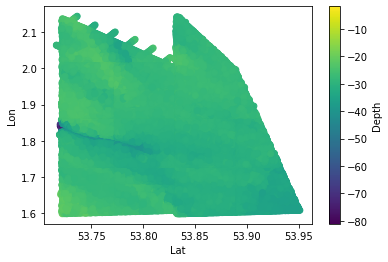

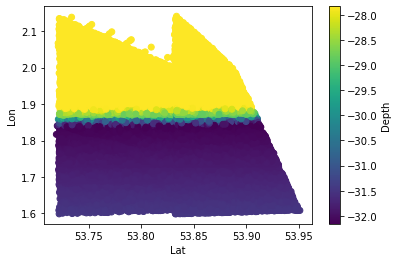

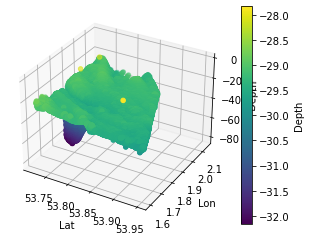

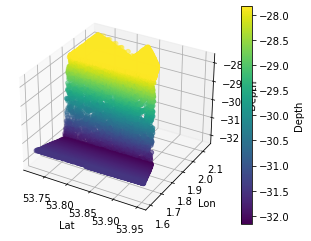

In [22]:
# plot Lat and Long colored by Depth
fig = plt.figure()
ax = fig.add_subplot(111)
map = ax.scatter(df['Lat'], df['Lon'], c=df['Depth'], cmap='viridis')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')
plt.show()

# plot Lat and Long colored by Depth
fig = plt.figure()
ax = fig.add_subplot(111)
map = ax.scatter(bathymetric_predicted['Lat'], bathymetric_predicted['Lon'], c=bathymetric_predicted['Depth'], cmap='viridis')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')
plt.show()

# plot Lat and Long and Depth, colored by Depth
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Lat'], df['Lon'], df['Depth'], c=df['Depth'], cmap='viridis')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
ax.set_zlabel('Depth')
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')
plt.show()

# plot Lat and Long and Depth, colored by Depth
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bathymetric_predicted['Lat'], bathymetric_predicted['Lon'], bathymetric_predicted['Depth'], c=bathymetric_predicted['Depth'], cmap='viridis')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
ax.set_zlabel('Depth')
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')
plt.show()

In [26]:
# load wind model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'wind_regression_model.h5'
model_path = os.path.join(save_dir, model_name)

if exists(model_path):  # load model if exists
    print(f"LOADING MODEL: {model_path}")
    wind_model = load_model(model_path)
else:   # else generate new model
    print("NO MODEL FOUND, BUILDING")

wind_model.summary()

LOADING MODEL: c:\Users\zacha\Documents\GitHub\plymouth-university-proj518\saved_models\wind_regression_model.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________

In [27]:
# load wind model input scaler
save_dir = os.path.join(os.getcwd(), 'saved_models')
scaler_name = 'wind_regression_scaler'
scaler_path = os.path.join(save_dir, scaler_name)

yscaler = joblib.load(scaler_path)

In [28]:
file = 'data/jan2020.nc.csv'
df = pd.read_csv(file, sep=',')

In [10]:
# predict values at same datapoints as csv
wind_predicted = mirror(wind_model, df, yscaler, columns=['Lat', 'Lon', 'Chi'])

NameError: name 'wind_model' is not defined

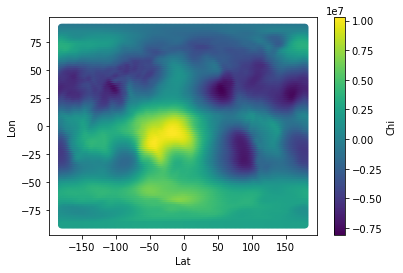

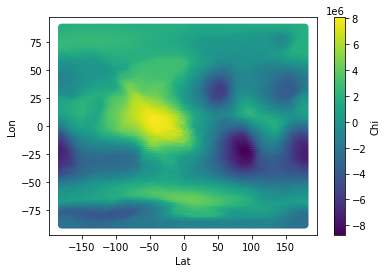

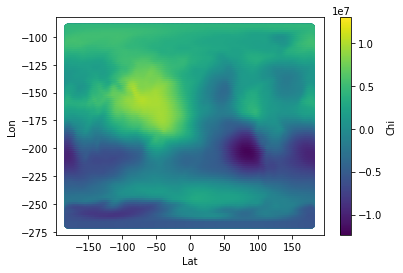

In [30]:
# plot Lat and Long colored by Depth
fig = plt.figure()
ax = fig.add_subplot(111)
map = ax.scatter(df['Lat'], df['Lon'], c=df['Chi'], cmap='viridis')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Chi')
plt.show()

# plot Lat and Long colored by Depth
fig = plt.figure()
ax = fig.add_subplot(111)
map = ax.scatter(wind_predicted['Lat'], wind_predicted['Lon'], c=wind_predicted['Chi'], cmap='viridis')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Chi')
plt.show()

file = 'data/2020 velocity potential .995 sigma.csv'
df = pd.read_csv(file, sep=',')

df[['Lon']] = df[['Lon']]-180.0
x = df[['Lat','Lon']]
y = df[['Chi']]

# plot Lat and Long colored by Depth
fig = plt.figure()
ax = fig.add_subplot(111)
map = ax.scatter(df['Lat'], df['Lon'], c=df['Chi'], cmap='viridis')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Chi')
plt.show()